In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow import expand_dims
from tensorflow.keras.losses import MeanAbsolutePercentageError
import tensorflow

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

/home/amirel/.pyenv/versions/3.8.12/envs/time_series/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-09 15:41:26.368408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-09 15:41:26.770293: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-09 15:41:26.797097: W tensorflow/stream_executor/p

# LSTM 2017-2018


In [507]:
df = pd.read_csv('../../AltInt/Inflation_prediction/raw_data/final_df.csv', index_col=0)


In [508]:
df.index = pd.to_datetime(df.index)
df

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,CPI,RPI,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI,RPI YOY
Date,,,,,,,,,,,,,,
2009-01-01,30.903838,33.424333,1.479027,1.099905,4308.390000,596.071497,2135.982324,12.472805,84.9,210.1,2.122545,3.757500,300.2,0.142993
2009-02-01,29.393166,33.617553,1.492643,1.120824,4232.114762,570.410394,2020.716905,9.467866,85.6,211.4,2.129905,3.798333,294.7,0.000000
2009-03-01,31.733352,36.826152,1.494241,1.097877,4107.840909,566.393975,2029.160819,8.064295,85.8,211.3,2.142045,3.872500,301.1,-0.377181
2009-04-01,33.990786,36.012519,1.511936,1.125327,4259.890500,588.042125,2119.383029,7.762397,86.0,211.5,2.143250,3.935500,302.9,-1.168224
2009-05-01,37.524515,38.801542,1.561252,1.131686,4434.719500,582.718727,2164.120107,7.757394,86.4,212.8,2.031900,3.917500,307.2,-1.069270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,120.8,337.1,2.538121,2.240542,538.4,11.659490
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,121.8,340.0,2.933563,2.626558,541.8,11.842105
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,122.5,343.2,2.700779,2.302258,541.0,12.340426


In [544]:
#rpi_lag = pd.read_csv('RPI_lagged.csv')


In [650]:
#rpi_lag

In [546]:
# rpi_lag = rpi_lag.rename({'Date CO1 Comdty': 'Date'}, axis=1)
# rpi_lag = rpi_lag.set_index('Date')


In [547]:
#rpi_lag.index = pd.to_datetime(rpi_lag.index)

In [548]:
#rpi_lag

,RPI_1y,RPI_2y,RPI_3y,RPI_4y,RPI_5y,RPI_6y,RPI_7y,RPI_8y,RPI_9y,RPI_10y,RPI_11y,RPI_12y
Date,,,,,,,,,,,,
2009-01-01,212.9,212.9,216.0,217.7,218.4,217.2,216.5,216.8,215.1,214.0,212.1,211.4
2009-02-01,210.1,210.1,212.9,216.0,217.7,218.4,217.2,216.5,216.8,215.1,214.0,212.1
2009-03-01,211.4,211.4,210.1,212.9,216.0,217.7,218.4,217.2,216.5,216.8,215.1,214.0
2009-04-01,211.3,211.3,211.4,210.1,212.9,216.0,217.7,218.4,217.2,216.5,216.8,215.1
2009-05-01,211.5,211.5,211.3,211.4,210.1,212.9,216.0,217.7,218.4,217.2,216.5,216.8
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,334.6,334.6,323.5,320.2,317.7,317.7,314.3,312.0,308.6,307.4,305.5,304.0
2022-06-01,337.1,337.1,334.6,323.5,320.2,317.7,317.7,314.3,312.0,308.6,307.4,305.5
2022-07-01,340.0,340.0,337.1,334.6,323.5,320.2,317.7,317.7,314.3,312.0,308.6,307.4


In [549]:
#new_df = df.join(rpi_lag)

In [550]:
#new_df

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,CPI,RPI,...,RPI_3y,RPI_4y,RPI_5y,RPI_6y,RPI_7y,RPI_8y,RPI_9y,RPI_10y,RPI_11y,RPI_12y
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,30.903838,33.424333,1.479027,1.099905,4308.390000,596.071497,2135.982324,12.472805,84.9,210.1,...,216.0,217.7,218.4,217.2,216.5,216.8,215.1,214.0,212.1,211.4
2009-02-01,29.393166,33.617553,1.492643,1.120824,4232.114762,570.410394,2020.716905,9.467866,85.6,211.4,...,212.9,216.0,217.7,218.4,217.2,216.5,216.8,215.1,214.0,212.1
2009-03-01,31.733352,36.826152,1.494241,1.097877,4107.840909,566.393975,2029.160819,8.064295,85.8,211.3,...,210.1,212.9,216.0,217.7,218.4,217.2,216.5,216.8,215.1,214.0
2009-04-01,33.990786,36.012519,1.511936,1.125327,4259.890500,588.042125,2119.383029,7.762397,86.0,211.5,...,211.4,210.1,212.9,216.0,217.7,218.4,217.2,216.5,216.8,215.1
2009-05-01,37.524515,38.801542,1.561252,1.131686,4434.719500,582.718727,2164.120107,7.757394,86.4,212.8,...,211.3,211.4,210.1,212.9,216.0,217.7,218.4,217.2,216.5,216.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,120.8,337.1,...,323.5,320.2,317.7,317.7,314.3,312.0,308.6,307.4,305.5,304.0
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,121.8,340.0,...,334.6,323.5,320.2,317.7,317.7,314.3,312.0,308.6,307.4,305.5
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,122.5,343.2,...,337.1,334.6,323.5,320.2,317.7,317.7,314.3,312.0,308.6,307.4


In [651]:
# X = new_df.drop(columns = ['RPI', 'CPI', 'RPI YOY'])
# y = new_df['RPI']

X = df.drop(columns = ['RPI', 'CPI', 'RPI YOY'])
y = df['RPI']

In [652]:
X[72:96]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2015-01-01,32.818125,31.737054,1.516177,1.336264,6641.765238,1339.503656,2495.664852,13.099203,0.858274,1.684729,375.9
2015-02-01,38.343255,32.759207,1.533386,1.362371,6746.840476,1356.232800,2536.801725,13.938965,0.952887,1.856450,375.0
2015-03-01,37.866261,31.635113,1.503677,1.377568,6791.140000,1380.431518,2615.694574,13.821672,0.947216,1.783045,377.9
2015-04-01,40.409377,35.572047,1.512909,1.386036,6886.650952,1381.813784,2620.084413,13.690119,0.923663,1.811432,385.1
2015-05-01,42.505052,36.186768,1.543548,1.384014,6864.994500,1360.216539,2568.111738,13.123988,1.009908,1.971630,389.3
2015-06-01,41.067582,35.885473,1.552386,1.385524,6687.803500,1340.919813,2507.691659,13.023503,1.061182,2.089545,389.1
2015-07-01,36.726002,31.989864,1.545617,1.402913,6625.526087,1353.218881,2518.626151,13.169073,1.119989,2.051104,390.2
2015-08-01,31.196110,29.152671,1.545248,1.376957,6402.255000,1311.027051,2434.955959,12.478583,1.085050,1.958367,389.6
2015-09-01,31.774855,30.721787,1.527609,1.364657,6280.524348,1302.101893,2375.712634,12.595702,1.004023,1.908904,390.2


In [653]:
X_train, y_train = X[:72], y[:72]
X_val, y_val = X[72:96], y[72:96]
X_test, y_test = X[96:108], y[96:108]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((72, 11), (72,), (24, 11), (24,), (12, 11), (12,))

In [654]:
y_train_x = expand_dims(y_train, -1)
y_train_x = expand_dims(y_train_x, -1)

y_train_x.shape

TensorShape([72, 1, 1])

In [655]:
y_val_x = expand_dims(y_val, -1)
y_val_x = expand_dims(y_val_x, -1)

In [656]:
y_val_x.shape

TensorShape([24, 1, 1])

In [657]:
X_test_x = expand_dims(X_test, -2)

In [658]:
X_test_x.shape

TensorShape([12, 1, 11])

In [659]:
X_train_x = expand_dims(X_train, -2)
X_train_x.shape

TensorShape([72, 1, 11])

In [660]:
X_val_x = expand_dims(X_val, -2)
X_val_x.shape

TensorShape([24, 1, 11])

In [661]:
lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps= 10_000, decay_rate=0.7)
adam = Adam(learning_rate=lr_scheduler)
es = EarlyStopping(patience=50, restore_best_weights=True)

In [662]:
normalizer = Normalization()
normalizer.adapt(X_train_x)

model1 = Sequential()
model1.add(normalizer)

model1.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model1.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model1.add(Flatten())

model1.add(Dense(100,activation =  'relu'))
model1.add(Dense(50,activation =  'relu'))
model1.add(Dense(25,activation =  'relu'))

model1.add(Dense(1, activation = 'linear'))

model1.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_27 (Normaliza  (None, None, 11)         23        
 tion)                                                           
                                                                 
 lstm_52 (LSTM)              (None, None, 100)         44800     
                                                                 
 lstm_53 (LSTM)              (None, 50)                30200     
                                                                 
 flatten_26 (Flatten)        (None, 50)                0         
                                                                 
 dense_104 (Dense)           (None, 100)               5100      
                                                                 
 dense_105 (Dense)           (None, 50)                5050      
                                                     

In [663]:
mape = MeanAbsolutePercentageError()

In [664]:
model1.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [665]:
model1.fit(X_train_x, y_train,batch_size = 32, validation_data=(X_val_x, y_val), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 8s 309ms/step - loss: 100.0000 - mape: 100.0000 - val_loss: 99.9957 - val_mape: 99.9957
Epoch 2/10000
3/3 [==============================] - 0s 22ms/step - loss: 99.9914 - mape: 99.9914 - val_loss: 99.9868 - val_mape: 99.9868
Epoch 3/10000
3/3 [==============================] - 0s 21ms/step - loss: 99.9812 - mape: 99.9812 - val_loss: 99.9741 - val_mape: 99.9741
Epoch 4/10000
3/3 [==============================] - 0s 22ms/step - loss: 99.9686 - mape: 99.9686 - val_loss: 99.9599 - val_mape: 99.9599
Epoch 5/10000
3/3 [==============================] - 0s 20ms/step - loss: 99.9519 - mape: 99.9519 - val_loss: 99.9437 - val_mape: 99.9437
Epoch 6/10000
3/3 [==============================] - 0s 19ms/step - loss: 99.9300 - mape: 99.9300 - val_loss: 99.9239 - val_mape: 99.9239
Epoch 7/10000
3/3 [==============================] - 0s 18ms/step - loss: 99.9011 - mape: 99.9011 - val_loss: 99.8980 - val_mape: 99.8980
Epoch 8/10000
3/3 [============

3/3 [==============================] - 0s 18ms/step - loss: 4.9454 - mape: 4.9454 - val_loss: 19.5217 - val_mape: 19.5217
Epoch 61/10000
3/3 [==============================] - 0s 18ms/step - loss: 4.8863 - mape: 4.8863 - val_loss: 19.0721 - val_mape: 19.0721
Epoch 62/10000
3/3 [==============================] - 0s 17ms/step - loss: 4.3745 - mape: 4.3745 - val_loss: 17.9570 - val_mape: 17.9570
Epoch 63/10000
3/3 [==============================] - 0s 17ms/step - loss: 4.1497 - mape: 4.1497 - val_loss: 19.6454 - val_mape: 19.6454
Epoch 64/10000
3/3 [==============================] - 0s 19ms/step - loss: 3.7908 - mape: 3.7908 - val_loss: 20.8309 - val_mape: 20.8309
Epoch 65/10000
3/3 [==============================] - 0s 18ms/step - loss: 3.6248 - mape: 3.6248 - val_loss: 19.8407 - val_mape: 19.8407
Epoch 66/10000
3/3 [==============================] - 0s 18ms/step - loss: 3.2263 - mape: 3.2263 - val_loss: 20.1021 - val_mape: 20.1021
Epoch 67/10000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 18ms/step - loss: 1.1355 - mape: 1.1355 - val_loss: 5.6087 - val_mape: 5.6087
Epoch 121/10000
3/3 [==============================] - 0s 19ms/step - loss: 1.1791 - mape: 1.1791 - val_loss: 5.0312 - val_mape: 5.0312
Epoch 122/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.8910 - mape: 0.8910 - val_loss: 6.0860 - val_mape: 6.0860
Epoch 123/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.0132 - mape: 1.0132 - val_loss: 5.5761 - val_mape: 5.5761
Epoch 124/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.7948 - mape: 0.7948 - val_loss: 5.0700 - val_mape: 5.0700
Epoch 125/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.7869 - mape: 0.7869 - val_loss: 5.3591 - val_mape: 5.3591
Epoch 126/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.8414 - mape: 0.8414 - val_loss: 5.2719 - val_mape: 5.2719
Epoch 127/10000
3/3 [==============================] - 0s 23ms/s

3/3 [==============================] - 0s 18ms/step - loss: 0.5175 - mape: 0.5175 - val_loss: 2.9170 - val_mape: 2.9170
Epoch 181/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5726 - mape: 0.5726 - val_loss: 2.8631 - val_mape: 2.8631
Epoch 182/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.4741 - mape: 0.4741 - val_loss: 3.1500 - val_mape: 3.1500
Epoch 183/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5906 - mape: 0.5906 - val_loss: 2.8919 - val_mape: 2.8919
Epoch 184/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5129 - mape: 0.5129 - val_loss: 2.8858 - val_mape: 2.8858
Epoch 185/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.7445 - mape: 0.7445 - val_loss: 2.8623 - val_mape: 2.8623
Epoch 186/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.5274 - mape: 0.5274 - val_loss: 2.8658 - val_mape: 2.8658
Epoch 187/10000
3/3 [==============================] - 0s 18ms/s

3/3 [==============================] - 0s 17ms/step - loss: 0.4784 - mape: 0.4784 - val_loss: 2.1503 - val_mape: 2.1503
Epoch 241/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.4046 - mape: 0.4046 - val_loss: 1.9772 - val_mape: 1.9772
Epoch 242/10000
3/3 [==============================] - 0s 19ms/step - loss: 0.3701 - mape: 0.3701 - val_loss: 2.0587 - val_mape: 2.0587
Epoch 243/10000
3/3 [==============================] - 0s 19ms/step - loss: 0.3794 - mape: 0.3794 - val_loss: 2.0970 - val_mape: 2.0970
Epoch 244/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.4176 - mape: 0.4176 - val_loss: 2.2193 - val_mape: 2.2193
Epoch 245/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.4734 - mape: 0.4734 - val_loss: 1.8987 - val_mape: 1.8987
Epoch 246/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.5845 - mape: 0.5845 - val_loss: 2.3305 - val_mape: 2.3305
Epoch 247/10000
3/3 [==============================] - 0s 19ms/s

3/3 [==============================] - 0s 17ms/step - loss: 0.5314 - mape: 0.5314 - val_loss: 1.7059 - val_mape: 1.7059
Epoch 301/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.7423 - mape: 0.7423 - val_loss: 1.6763 - val_mape: 1.6763
Epoch 302/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5098 - mape: 0.5098 - val_loss: 1.7380 - val_mape: 1.7380
Epoch 303/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.6255 - mape: 0.6255 - val_loss: 2.0341 - val_mape: 2.0341
Epoch 304/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.4027 - mape: 0.4027 - val_loss: 1.5233 - val_mape: 1.5233
Epoch 305/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.4139 - mape: 0.4139 - val_loss: 1.8072 - val_mape: 1.8072
Epoch 306/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.3500 - mape: 0.3500 - val_loss: 1.6693 - val_mape: 1.6693
Epoch 307/10000
3/3 [==============================] - 0s 18ms/s

3/3 [==============================] - 0s 18ms/step - loss: 0.2780 - mape: 0.2780 - val_loss: 1.5205 - val_mape: 1.5205
Epoch 361/10000
3/3 [==============================] - 0s 19ms/step - loss: 0.3517 - mape: 0.3517 - val_loss: 1.8550 - val_mape: 1.8550
Epoch 362/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5087 - mape: 0.5087 - val_loss: 1.5774 - val_mape: 1.5774
Epoch 363/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.4394 - mape: 0.4394 - val_loss: 1.8597 - val_mape: 1.8597
Epoch 364/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.5760 - mape: 0.5760 - val_loss: 1.5333 - val_mape: 1.5333
Epoch 365/10000
3/3 [==============================] - 0s 19ms/step - loss: 0.5821 - mape: 0.5821 - val_loss: 1.6489 - val_mape: 1.6489
Epoch 366/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5176 - mape: 0.5176 - val_loss: 1.7301 - val_mape: 1.7301
Epoch 367/10000
3/3 [==============================] - 0s 19ms/s

3/3 [==============================] - 0s 33ms/step - loss: 0.2851 - mape: 0.2851 - val_loss: 1.6766 - val_mape: 1.6766
Epoch 421/10000
3/3 [==============================] - 0s 21ms/step - loss: 0.3499 - mape: 0.3499 - val_loss: 1.7388 - val_mape: 1.7388
Epoch 422/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.3324 - mape: 0.3324 - val_loss: 1.6648 - val_mape: 1.6648
Epoch 423/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.2477 - mape: 0.2477 - val_loss: 1.6042 - val_mape: 1.6042
Epoch 424/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.2676 - mape: 0.2676 - val_loss: 1.6954 - val_mape: 1.6954
Epoch 425/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.2708 - mape: 0.2708 - val_loss: 1.7257 - val_mape: 1.7257
Epoch 426/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.3342 - mape: 0.3342 - val_loss: 1.6867 - val_mape: 1.6867
Epoch 427/10000
3/3 [==============================] - 0s 17ms/s

In [666]:
model1.predict(X_test_x)

1/1 [==============================] - 1s 523ms/step


array([[261.63675],
       [261.8891 ],
       [261.36542],
       [262.15912],
       [262.18994],
       [261.9997 ],
       [261.8278 ],
       [261.6873 ],
       [262.32794],
       [262.3012 ],
       [262.7959 ],
       [263.25903]], dtype=float32)

In [667]:
test_predictions = list(model1.predict(X_test_x))
test_results = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results['date'] = list(y_test.index)
test_results['test_predictions'] = [x[0] for x in test_predictions]
test_results['test_actual'] = list(y_test)


1/1 [==============================] - 0s 22ms/step


In [668]:
test_results

,test_predictions,test_actual,date
0,261.636749,265.5,2017-01-01
1,261.889099,268.4,2017-02-01
2,261.365417,269.3,2017-03-01
3,262.159119,270.6,2017-04-01
4,262.189941,271.7,2017-05-01
5,261.999695,272.3,2017-06-01
6,261.827789,272.9,2017-07-01
7,261.687286,274.7,2017-08-01
8,262.327942,275.1,2017-09-01
9,262.301208,275.3,2017-10-01


In [669]:
test_results.set_index('date', inplace=True)

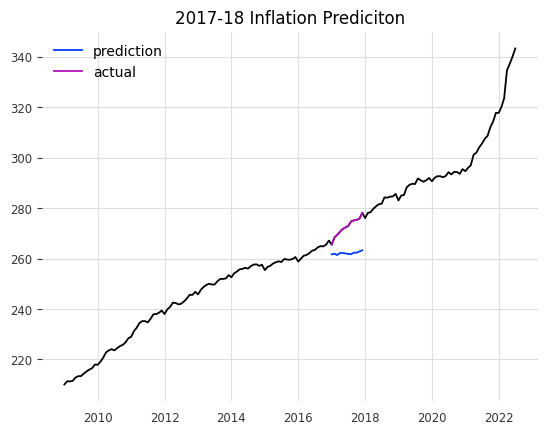

In [670]:
import matplotlib.pyplot as plt

plt.plot(y)
plt.plot(test_results['test_predictions'], label='prediction')
plt.plot(test_results['test_actual'], label='actual')
plt.title('2017-18 Inflation Prediciton')
plt.legend()
#plt.savefig('LSTM_new')



# LSTM 2018-2019

In [671]:
X_train1, y_train1 = X[:84], y[:84]
X_val1, y_val1 = X[84:108], y[84:108]
X_test1, y_test1 = X[108:120], y[108:120]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((84, 11), (84,), (24, 11), (24,), (12, 11), (12,))

In [672]:
y_train1_x = expand_dims(y_train1, -1)
y_train1_x = expand_dims(y_train1_x, -1)

y_train1_x.shape

TensorShape([84, 1, 1])

In [673]:
y_val1_x = expand_dims(y_val1, -1)
y_val1_x = expand_dims(y_val1_x, -1)

In [674]:
X_test1_x = expand_dims(X_test1, -2)

In [675]:
X_train1_x = expand_dims(X_train1, -2)
X_train1_x.shape

TensorShape([84, 1, 11])

In [676]:
X_val1_x = expand_dims(X_val1, -2)
X_val1_x.shape

TensorShape([24, 1, 11])

In [677]:
lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps= 10_000, decay_rate=0.7)
adam = Adam(learning_rate=lr_scheduler)
es = EarlyStopping(patience=50, restore_best_weights=True)

In [678]:
normalizer = Normalization()
normalizer.adapt(X_train1_x)

model2 = Sequential()
model2.add(normalizer)

model2.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model2.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model2.add(Flatten())

model2.add(Dense(100,activation =  'relu'))
model2.add(Dense(50,activation =  'relu'))
model2.add(Dense(25,activation =  'relu'))

model2.add(Dense(1, activation = 'linear'))

model2.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_28 (Normaliza  (None, None, 11)         23        
 tion)                                                           
                                                                 
 lstm_54 (LSTM)              (None, None, 100)         44800     
                                                                 
 lstm_55 (LSTM)              (None, 50)                30200     
                                                                 
 flatten_27 (Flatten)        (None, 50)                0         
                                                                 
 dense_108 (Dense)           (None, 100)               5100      
                                                                 
 dense_109 (Dense)           (None, 50)                5050      
                                                     

In [679]:
model2.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [680]:
model2.fit(X_train1_x, y_train1,batch_size = 32, validation_data=(X_val1_x, y_val1), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 3s 291ms/step - loss: 99.9985 - mape: 99.9985 - val_loss: 99.9867 - val_mape: 99.9867
Epoch 2/10000
3/3 [==============================] - 0s 19ms/step - loss: 99.9854 - mape: 99.9854 - val_loss: 99.9632 - val_mape: 99.9632
Epoch 3/10000
3/3 [==============================] - 0s 19ms/step - loss: 99.9684 - mape: 99.9684 - val_loss: 99.9318 - val_mape: 99.9318
Epoch 4/10000
3/3 [==============================] - 0s 21ms/step - loss: 99.9474 - mape: 99.9474 - val_loss: 99.8906 - val_mape: 99.8906
Epoch 5/10000
3/3 [==============================] - 0s 20ms/step - loss: 99.9207 - mape: 99.9207 - val_loss: 99.8356 - val_mape: 99.8356
Epoch 6/10000
3/3 [==============================] - 0s 21ms/step - loss: 99.8860 - mape: 99.8860 - val_loss: 99.7599 - val_mape: 99.7599
Epoch 7/10000
3/3 [==============================] - 0s 21ms/step - loss: 99.8400 - mape: 99.8400 - val_loss: 99.6505 - val_mape: 99.6505
Epoch 8/10000
3/3 [==============

3/3 [==============================] - 0s 18ms/step - loss: 3.2158 - mape: 3.2158 - val_loss: 8.3014 - val_mape: 8.3014
Epoch 61/10000
3/3 [==============================] - 0s 18ms/step - loss: 3.1851 - mape: 3.1851 - val_loss: 7.7754 - val_mape: 7.7754
Epoch 62/10000
3/3 [==============================] - 0s 17ms/step - loss: 2.9137 - mape: 2.9137 - val_loss: 8.8738 - val_mape: 8.8738
Epoch 63/10000
3/3 [==============================] - 0s 17ms/step - loss: 2.8501 - mape: 2.8501 - val_loss: 8.2618 - val_mape: 8.2618
Epoch 64/10000
3/3 [==============================] - 0s 17ms/step - loss: 2.6858 - mape: 2.6858 - val_loss: 7.1878 - val_mape: 7.1878
Epoch 65/10000
3/3 [==============================] - 0s 19ms/step - loss: 2.6333 - mape: 2.6333 - val_loss: 7.2456 - val_mape: 7.2456
Epoch 66/10000
3/3 [==============================] - 0s 19ms/step - loss: 2.5174 - mape: 2.5174 - val_loss: 6.1993 - val_mape: 6.1993
Epoch 67/10000
3/3 [==============================] - 0s 17ms/step - l

3/3 [==============================] - 0s 17ms/step - loss: 0.9262 - mape: 0.9262 - val_loss: 2.1723 - val_mape: 2.1723
Epoch 121/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.7653 - mape: 0.7653 - val_loss: 2.1043 - val_mape: 2.1043
Epoch 122/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.7470 - mape: 0.7470 - val_loss: 1.6905 - val_mape: 1.6905
Epoch 123/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.7763 - mape: 0.7763 - val_loss: 2.4819 - val_mape: 2.4819
Epoch 124/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.6983 - mape: 0.6983 - val_loss: 1.4677 - val_mape: 1.4677
Epoch 125/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.8173 - mape: 0.8173 - val_loss: 1.6776 - val_mape: 1.6776
Epoch 126/10000
3/3 [==============================] - 0s 19ms/step - loss: 0.7104 - mape: 0.7104 - val_loss: 1.5660 - val_mape: 1.5660
Epoch 127/10000
3/3 [==============================] - 0s 17ms/s

In [681]:
test_prediction1 = list(model2.predict(X_test1_x))

1/1 [==============================] - 1s 554ms/step


In [682]:
test_results1 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results1['date'] = list(y_test1.index)
test_results1['test_predictions'] = [x[0] for x in test_prediction1]
test_results1['test_actual'] = list(y_test1)

In [683]:
test_results1

,test_predictions,test_actual,date
0,278.015839,276.0,2018-01-01
1,273.952606,278.1,2018-02-01
2,274.301849,278.3,2018-03-01
3,275.647797,279.7,2018-04-01
4,276.636322,280.7,2018-05-01
5,276.941437,281.5,2018-06-01
6,277.683990,281.7,2018-07-01
7,276.475861,284.2,2018-08-01
8,278.097412,284.1,2018-09-01
9,273.814789,284.5,2018-10-01


In [684]:
test_results1.set_index('date', inplace=True)

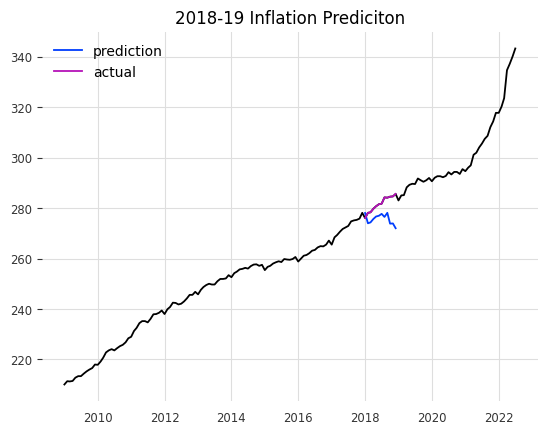

In [685]:
plt.plot(y)
plt.plot(test_results1['test_predictions'], label='prediction')
plt.plot(test_results1['test_actual'], label='actual')
plt.title('2018-19 Inflation Prediciton')
plt.legend()

# LSTM 2019-2020

In [686]:
X_train2, y_train2 = X[:96], y[:96]
X_val2, y_val2 = X[96:120], y[96:120]
X_test2, y_test2 = X[120:132], y[120:132]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((96, 11), (96,), (24, 11), (24,), (12, 11), (12,))

In [687]:
y_train2_x = expand_dims(y_train2, -1)
y_train2_x = expand_dims(y_train2_x, -1)

y_train2_x.shape

TensorShape([96, 1, 1])

In [688]:
y_val2_x = expand_dims(y_val2, -1)
y_val2_x = expand_dims(y_val2_x, -1)

In [689]:
X_test2_x = expand_dims(X_test2, -2)

In [690]:
X_train2_x = expand_dims(X_train2, -2)
X_train2_x.shape

TensorShape([96, 1, 11])

In [691]:
X_val2_x = expand_dims(X_val2, -2)
X_val2_x.shape

TensorShape([24, 1, 11])

In [692]:
normalizer = Normalization()
normalizer.adapt(X_train2_x)

model3 = Sequential()
model3.add(normalizer)

model3.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model3.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model3.add(Flatten())

model3.add(Dense(100,activation =  'relu'))
model3.add(Dense(50,activation =  'relu'))
model3.add(Dense(25,activation =  'relu'))

model3.add(Dense(1, activation = 'linear'))

model3.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_29 (Normaliza  (None, None, 11)         23        
 tion)                                                           
                                                                 
 lstm_56 (LSTM)              (None, None, 100)         44800     
                                                                 
 lstm_57 (LSTM)              (None, 50)                30200     
                                                                 
 flatten_28 (Flatten)        (None, 50)                0         
                                                                 
 dense_112 (Dense)           (None, 100)               5100      
                                                                 
 dense_113 (Dense)           (None, 50)                5050      
                                                     

In [693]:
model3.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [694]:
model3.fit(X_train2_x, y_train2,batch_size = 32, validation_data=(X_val2_x, y_val2), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 3s 295ms/step - loss: 99.9978 - mape: 99.9978 - val_loss: 99.9897 - val_mape: 99.9897
Epoch 2/10000
3/3 [==============================] - 0s 20ms/step - loss: 99.9741 - mape: 99.9741 - val_loss: 99.9639 - val_mape: 99.9639
Epoch 3/10000
3/3 [==============================] - 0s 20ms/step - loss: 99.9255 - mape: 99.9255 - val_loss: 99.9253 - val_mape: 99.9253
Epoch 4/10000
3/3 [==============================] - 0s 20ms/step - loss: 99.8116 - mape: 99.8116 - val_loss: 99.8675 - val_mape: 99.8675
Epoch 5/10000
3/3 [==============================] - 0s 20ms/step - loss: 99.5471 - mape: 99.5471 - val_loss: 99.7801 - val_mape: 99.7801
Epoch 6/10000
3/3 [==============================] - 0s 20ms/step - loss: 98.8205 - mape: 98.8205 - val_loss: 99.6394 - val_mape: 99.6394
Epoch 7/10000
3/3 [==============================] - 0s 18ms/step - loss: 97.3672 - mape: 97.3672 - val_loss: 99.4230 - val_mape: 99.4230
Epoch 8/10000
3/3 [==============

Epoch 61/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.6692 - mape: 1.6692 - val_loss: 4.1829 - val_mape: 4.1829
Epoch 62/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.5564 - mape: 1.5564 - val_loss: 3.8097 - val_mape: 3.8097
Epoch 63/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.4834 - mape: 1.4834 - val_loss: 3.8498 - val_mape: 3.8498
Epoch 64/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.4682 - mape: 1.4682 - val_loss: 3.6656 - val_mape: 3.6656
Epoch 65/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.5170 - mape: 1.5170 - val_loss: 3.2628 - val_mape: 3.2628
Epoch 66/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.5230 - mape: 1.5230 - val_loss: 3.2410 - val_mape: 3.2410
Epoch 67/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.4481 - mape: 1.4481 - val_loss: 3.6872 - val_mape: 3.6872
Epoch 68/10000
3/3 [==============================] - 0

3/3 [==============================] - 0s 16ms/step - loss: 0.6267 - mape: 0.6267 - val_loss: 2.6998 - val_mape: 2.6998
Epoch 122/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.6377 - mape: 0.6377 - val_loss: 2.5954 - val_mape: 2.5954
Epoch 123/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.5993 - mape: 0.5993 - val_loss: 3.0034 - val_mape: 3.0034
Epoch 124/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.6002 - mape: 0.6002 - val_loss: 2.8626 - val_mape: 2.8626
Epoch 125/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.6516 - mape: 0.6516 - val_loss: 3.0210 - val_mape: 3.0210
Epoch 126/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.6699 - mape: 0.6699 - val_loss: 3.2280 - val_mape: 3.2280
Epoch 127/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.6182 - mape: 0.6182 - val_loss: 3.1867 - val_mape: 3.1867
Epoch 128/10000
3/3 [==============================] - 0s 18ms/s

In [695]:
test_prediction2 = list(model3.predict(X_test2_x))


1/1 [==============================] - 1s 574ms/step


In [696]:
test_results2 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results2['date'] = list(y_test2.index)
test_results2['test_predictions'] = [x[0] for x in test_prediction2]
test_results2['test_actual'] = list(y[120:132])

In [697]:
test_results2.set_index('date', inplace=True)

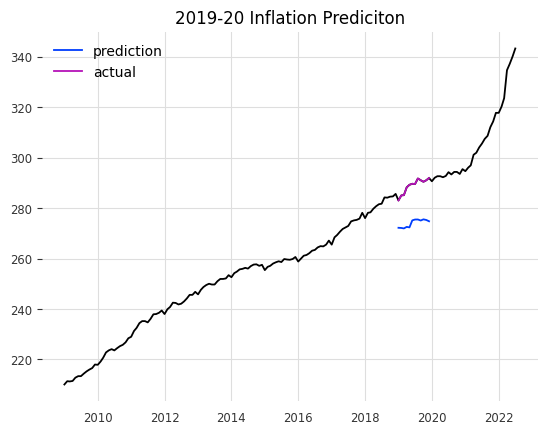

In [698]:
plt.plot(y)
plt.plot(test_results2['test_predictions'], label='prediction')
plt.plot(test_results2['test_actual'], label='actual')
plt.title('2019-20 Inflation Prediciton')
plt.legend()
#plt.savefig('LSTM_2019-20')

# LSTM 2020-2021

In [699]:
X[132:144]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2020-01-01,49.021977,37.434634,1.298861,1.160843,7036.697727,2497.268828,3060.333106,7.781994,0.692330,0.710236,430.7
2020-02-01,42.943990,35.965277,1.291857,1.164014,6796.644286,2501.024605,3019.880708,7.418630,0.683318,0.645300,431.1
2020-03-01,27.211757,25.801736,1.239504,1.111822,5813.382174,2243.053117,2631.283557,6.975790,0.496927,0.614401,438.0
2020-04-01,21.072957,17.991584,1.263773,1.139632,6002.315714,2370.656764,2666.200693,5.995653,0.470125,0.524649,444.7
2020-05-01,25.990237,28.047836,1.247080,1.123495,6134.460000,2450.288506,2722.792714,4.950512,0.327838,0.459777,436.7
2020-06-01,32.338286,31.462164,1.260819,1.118319,6267.593333,2475.319143,2906.093329,5.429804,0.243187,0.453932,431.7
2020-07-01,33.762927,31.986664,1.280167,1.112688,6244.110000,2520.160305,2990.676103,5.291466,0.139427,0.406336,440.7
2020-08-01,34.536521,31.706150,1.303548,1.117148,6163.494211,2569.477068,2952.475053,6.921193,0.104939,0.457958,447.1
2020-09-01,32.488230,30.814480,1.288886,1.106245,6078.599545,2558.413712,2949.601847,8.556717,0.066389,0.432595,451.1


In [700]:
X_train3, y_train3 = X[:108], y[:108]
X_val3, y_val3 = X[108:132], y[108:132]
X_test3, y_test3 = X[132:144], y[132:144]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((108, 11), (108,), (24, 11), (24,), (12, 11), (12,))

In [701]:
y_train3_x = expand_dims(y_train3, -1)
y_train3_x = expand_dims(y_train3_x, -1)

y_train3_x.shape

TensorShape([108, 1, 1])

In [702]:
y_val3_x = expand_dims(y_val3, -1)
y_val3_x = expand_dims(y_val3_x, -1)

In [703]:
X_test3_x = expand_dims(X_test3, -2)

In [704]:
X_train3_x = expand_dims(X_train3, -2)
X_train3_x.shape

TensorShape([108, 1, 11])

In [705]:
X_val3_x = expand_dims(X_val3, -2)
X_val3_x.shape

TensorShape([24, 1, 11])

In [706]:
normalizer = Normalization()
normalizer.adapt(X_train3_x)

model4 = Sequential()
model4.add(normalizer)

model4.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model4.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model4.add(Flatten())

model4.add(Dense(100,activation =  'relu'))
model4.add(Dense(50,activation =  'relu'))
model4.add(Dense(25,activation =  'relu'))

model4.add(Dense(1, activation = 'linear'))

model4.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_30 (Normaliza  (None, None, 11)         23        
 tion)                                                           
                                                                 
 lstm_58 (LSTM)              (None, None, 100)         44800     
                                                                 
 lstm_59 (LSTM)              (None, 50)                30200     
                                                                 
 flatten_29 (Flatten)        (None, 50)                0         
                                                                 
 dense_116 (Dense)           (None, 100)               5100      
                                                                 
 dense_117 (Dense)           (None, 50)                5050      
                                                     

In [707]:
model4.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [708]:
model4.fit(X_train3_x, y_train3,batch_size = 32, validation_data=(X_val3_x, y_val3), epochs=10000, callbacks = (es))

Epoch 1/10000
4/4 [==============================] - 4s 218ms/step - loss: 99.9778 - mape: 99.9778 - val_loss: 99.8824 - val_mape: 99.8824
Epoch 2/10000
4/4 [==============================] - 0s 16ms/step - loss: 99.8006 - mape: 99.8006 - val_loss: 99.3601 - val_mape: 99.3601
Epoch 3/10000
4/4 [==============================] - 0s 17ms/step - loss: 99.0880 - mape: 99.0880 - val_loss: 97.3608 - val_mape: 97.3608
Epoch 4/10000
4/4 [==============================] - 0s 17ms/step - loss: 96.4795 - mape: 96.4795 - val_loss: 91.0416 - val_mape: 91.0416
Epoch 5/10000
4/4 [==============================] - 0s 16ms/step - loss: 88.7453 - mape: 88.7453 - val_loss: 76.3729 - val_mape: 76.3729
Epoch 6/10000
4/4 [==============================] - 0s 16ms/step - loss: 70.7469 - mape: 70.7469 - val_loss: 50.6390 - val_mape: 50.6390
Epoch 7/10000
4/4 [==============================] - 0s 16ms/step - loss: 37.1047 - mape: 37.1047 - val_loss: 7.4911 - val_mape: 7.4911
Epoch 8/10000
4/4 [================

4/4 [==============================] - 0s 12ms/step - loss: 0.9481 - mape: 0.9481 - val_loss: 4.4319 - val_mape: 4.4319
Epoch 62/10000
4/4 [==============================] - 0s 14ms/step - loss: 0.9290 - mape: 0.9290 - val_loss: 5.7080 - val_mape: 5.7080
Epoch 63/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.0328 - mape: 1.0328 - val_loss: 3.5511 - val_mape: 3.5511
Epoch 64/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.1357 - mape: 1.1357 - val_loss: 5.6816 - val_mape: 5.6816


In [709]:
test_prediction3 = list(model4.predict(X_test3_x))


1/1 [==============================] - 1s 656ms/step


In [710]:
test_results3 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results3['date'] = list(y_test3.index)
test_results3['test_predictions'] = [x[0] for x in test_prediction3]
test_results3['test_actual'] = list(y_test3)

In [711]:
test_results3.set_index('date', inplace=True)

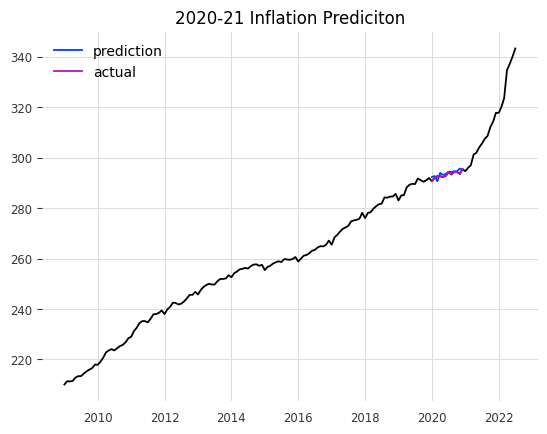

In [714]:
plt.plot(y)
plt.plot(test_results3['test_predictions'], label='prediction')
plt.plot(test_results3['test_actual'], label='actual')
plt.title('2020-21 Inflation Prediciton')
plt.legend()
plt.savefig('LSTM_2020-21')

# LSTM 2021-2022

In [715]:
X[:165]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2009-01-01,30.903838,33.424333,1.479027,1.099905,4308.390000,596.071497,2135.982324,12.472805,2.122545,3.757500,300.2
2009-02-01,29.393166,33.617553,1.492643,1.120824,4232.114762,570.410394,2020.716905,9.467866,2.129905,3.798333,294.7
2009-03-01,31.733352,36.826152,1.494241,1.097877,4107.840909,566.393975,2029.160819,8.064295,2.142045,3.872500,301.1
2009-04-01,33.990786,36.012519,1.511936,1.125327,4259.890500,588.042125,2119.383029,7.762397,2.143250,3.935500,302.9
2009-05-01,37.524515,38.801542,1.561252,1.131686,4434.719500,582.718727,2164.120107,7.757394,2.031900,3.917500,307.2
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,2.538121,2.240542,538.4
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,2.933563,2.626558,541.8
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,2.700779,2.302258,541.0


In [716]:
X_train4, y_train4 = X[:132], y[:132]
X_val4, y_val4 = X[132:156], y[132:156]
X_test4, y_test4 = X[156:165], y[156:165]
X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

((132, 11), (132,), (24, 11), (24,), (9, 11), (9,))

In [717]:
y_train4_x = expand_dims(y_train4, -1)
y_train4_x = expand_dims(y_train4_x, -1)

y_train4_x.shape

TensorShape([132, 1, 1])

In [718]:
y_val4_x = expand_dims(y_val4, -1)
y_val4_x = expand_dims(y_val4_x, -1)

In [719]:
X_test4_x = expand_dims(X_test4, -2)

In [720]:
X_train4_x = expand_dims(X_train4, -2)
X_train4_x.shape

TensorShape([132, 1, 11])

In [721]:
X_val4_x = expand_dims(X_val4, -2)
X_val4_x.shape

TensorShape([24, 1, 11])

In [722]:
normalizer = Normalization()
normalizer.adapt(X_train4_x)

model5 = Sequential()
model5.add(normalizer)

model5.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model5.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model5.add(Flatten())

model5.add(Dense(100,activation =  'relu'))
model5.add(Dense(50,activation =  'relu'))
model5.add(Dense(25,activation =  'relu'))

model5.add(Dense(1, activation = 'linear'))

model5.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliza  (None, None, 11)         23        
 tion)                                                           
                                                                 
 lstm_60 (LSTM)              (None, None, 100)         44800     
                                                                 
 lstm_61 (LSTM)              (None, 50)                30200     
                                                                 
 flatten_30 (Flatten)        (None, 50)                0         
                                                                 
 dense_120 (Dense)           (None, 100)               5100      
                                                                 
 dense_121 (Dense)           (None, 50)                5050      
                                                     

In [723]:
model5.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [724]:
model5.fit(X_train4_x, y_train4,batch_size = 32, validation_data=(X_val4_x, y_val4), epochs=10000, callbacks = (es))

Epoch 1/10000
5/5 [==============================] - 3s 149ms/step - loss: 99.9708 - mape: 99.9708 - val_loss: 99.8090 - val_mape: 99.8090
Epoch 2/10000
5/5 [==============================] - 0s 12ms/step - loss: 99.6559 - mape: 99.6559 - val_loss: 98.1734 - val_mape: 98.1734
Epoch 3/10000
5/5 [==============================] - 0s 12ms/step - loss: 97.6677 - mape: 97.6677 - val_loss: 88.7055 - val_mape: 88.7055
Epoch 4/10000
5/5 [==============================] - 0s 13ms/step - loss: 88.0327 - mape: 88.0327 - val_loss: 57.2935 - val_mape: 57.2935
Epoch 5/10000
5/5 [==============================] - 0s 13ms/step - loss: 61.4763 - mape: 61.4763 - val_loss: 14.2016 - val_mape: 14.2016
Epoch 6/10000
5/5 [==============================] - 0s 14ms/step - loss: 33.1138 - mape: 33.1138 - val_loss: 37.8074 - val_mape: 37.8074
Epoch 7/10000
5/5 [==============================] - 0s 13ms/step - loss: 25.6494 - mape: 25.6494 - val_loss: 3.9493 - val_mape: 3.9493
Epoch 8/10000
5/5 [================

5/5 [==============================] - 0s 10ms/step - loss: 1.0915 - mape: 1.0915 - val_loss: 3.3420 - val_mape: 3.3420
Epoch 62/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.1524 - mape: 1.1524 - val_loss: 2.9813 - val_mape: 2.9813
Epoch 63/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3344 - mape: 1.3344 - val_loss: 1.8560 - val_mape: 1.8560
Epoch 64/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.4028 - mape: 1.4028 - val_loss: 2.8713 - val_mape: 2.8713
Epoch 65/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.4233 - mape: 1.4233 - val_loss: 3.3766 - val_mape: 3.3766
Epoch 66/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2681 - mape: 1.2681 - val_loss: 1.6218 - val_mape: 1.6218
Epoch 67/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.2994 - mape: 1.2994 - val_loss: 2.8059 - val_mape: 2.8059
Epoch 68/10000
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 12ms/step - loss: 0.8387 - mape: 0.8387 - val_loss: 3.0405 - val_mape: 3.0405
Epoch 122/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.9980 - mape: 0.9980 - val_loss: 0.6876 - val_mape: 0.6876
Epoch 123/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.9101 - mape: 0.9101 - val_loss: 2.0029 - val_mape: 2.0029
Epoch 124/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.8399 - mape: 0.8399 - val_loss: 1.4435 - val_mape: 1.4435
Epoch 125/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.8304 - mape: 0.8304 - val_loss: 1.5675 - val_mape: 1.5675
Epoch 126/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7090 - mape: 0.7090 - val_loss: 1.1546 - val_mape: 1.1546
Epoch 127/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.7694 - mape: 0.7694 - val_loss: 1.9720 - val_mape: 1.9720
Epoch 128/10000
5/5 [==============================] - 0s 10ms/s

5/5 [==============================] - 0s 10ms/step - loss: 0.5915 - mape: 0.5915 - val_loss: 1.7352 - val_mape: 1.7352
Epoch 182/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.6377 - mape: 0.6377 - val_loss: 0.6880 - val_mape: 0.6880
Epoch 183/10000
5/5 [==============================] - 0s 11ms/step - loss: 0.7582 - mape: 0.7582 - val_loss: 1.8567 - val_mape: 1.8567
Epoch 184/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.6729 - mape: 0.6729 - val_loss: 1.2315 - val_mape: 1.2315
Epoch 185/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.6210 - mape: 0.6210 - val_loss: 0.7976 - val_mape: 0.7976
Epoch 186/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.5724 - mape: 1.5724 - val_loss: 0.6303 - val_mape: 0.6303
Epoch 187/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3199 - mape: 1.3199 - val_loss: 1.5907 - val_mape: 1.5907
Epoch 188/10000
5/5 [==============================] - 0s 10ms/s

In [785]:
test_prediction4 = list(model5.predict(X_test4_x))
test_prediction4


1/1 [==============================] - 0s 36ms/step


[array([331.24274], dtype=float32),
 array([254.95024], dtype=float32),
 array([313.0604], dtype=float32),
 array([303.8671], dtype=float32),
 array([342.8013], dtype=float32),
 array([323.93756], dtype=float32),
 array([334.2055], dtype=float32),
 array([332.9833], dtype=float32),
 array([5.235327], dtype=float32)]

In [786]:
test_results4 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results4['date'] = list(y_test4.index)
test_results4['test_predictions'] = [x[0] for x in test_prediction4]
test_results4['test_actual'] = list(y_test4)

In [788]:
test_results4.set_index('date', inplace=True)

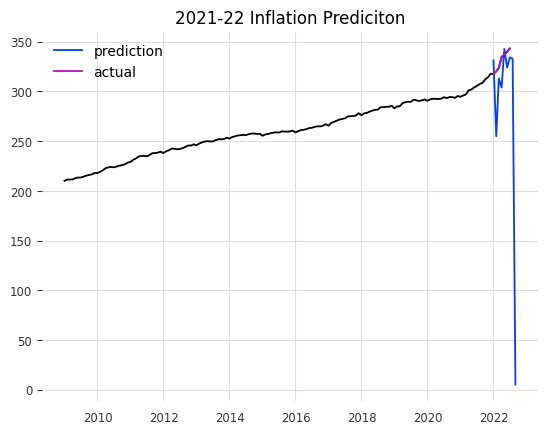

In [790]:
plt.plot(y)
plt.plot(test_results4['test_predictions'], label='prediction')
plt.plot(test_results4['test_actual'], label='actual')
plt.title('2021-22 Inflation Prediciton')
plt.legend()

# LSTM 2022-

In [742]:
X[156:165]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2022-01-01,64.727038,68.604778,1.322050,1.192165,7462.046000,3308.798338,3397.992308,78.466208,1.894165,1.725929,509.8
2022-02-01,71.248057,72.438471,1.320759,1.193094,7475.330000,3264.127351,3303.366925,79.209516,2.230094,1.866820,519.1
2022-03-01,86.000645,79.203181,1.307700,1.190955,7425.606111,3386.752313,3266.616707,85.360798,2.186532,1.899921,529.3
2022-04-01,82.294714,78.884404,1.287045,1.194540,7475.842222,3390.642475,3202.490777,86.613133,2.365979,2.085100,533.9
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,2.538121,2.240542,538.4
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,2.933563,2.626558,541.8
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,2.700779,2.302258,541.0
2022-08-01,80.656541,78.913331,1.211816,1.181732,7453.987222,3446.779300,3131.457852,180.082147,3.368889,2.688500,546.1
2022-09-01,73.474167,80.706056,1.272420,1.180400,7403.016000,3300.260920,3208.537784,93.341821,2.475340,2.155940,NaN


In [743]:
X_train5, y_train5 = X[:156], y[:156]
X_val5, y_val5 = X[159:165], y[159:165]
X_test5, y_test5 = X[159:165], y[159:165]
X_train5.shape, y_train5.shape, X_val5.shape, y_val5.shape, X_test5.shape, y_test5.shape

((156, 11), (156,), (6, 11), (6,), (6, 11), (6,))

In [744]:
y_train5_x = expand_dims(y_train5, -1)
y_train5_x = expand_dims(y_train5_x, -1)

y_train5_x.shape

TensorShape([156, 1, 1])

In [745]:
y_val5_x = expand_dims(y_val5, -1)
y_val5_x = expand_dims(y_val5_x, -1)

In [746]:
X_test5_x = expand_dims(X_test5, -2)

In [747]:
X_train5_x = expand_dims(X_train5, -2)
X_train5_x.shape

TensorShape([156, 1, 11])

In [748]:
X_val5_x = expand_dims(X_val5, -2)
X_val5_x.shape

TensorShape([6, 1, 11])

In [764]:
normalizer = Normalization()
normalizer.adapt(X_train5_x)

model6 = Sequential()
model6.add(normalizer)

model6.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model6.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model6.add(Flatten())

model6.add(Dense(100,activation =  'relu'))
model6.add(Dense(50,activation =  'relu'))
model6.add(Dense(25,activation =  'relu'))

model6.add(Dense(1, activation = 'linear'))

model6.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_33 (Normaliza  (None, None, 11)         23        
 tion)                                                           
                                                                 
 lstm_64 (LSTM)              (None, None, 100)         44800     
                                                                 
 lstm_65 (LSTM)              (None, 50)                30200     
                                                                 
 flatten_32 (Flatten)        (None, 50)                0         
                                                                 
 dense_128 (Dense)           (None, 100)               5100      
                                                                 
 dense_129 (Dense)           (None, 50)                5050      
                                                     

In [765]:
model6.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [766]:
model6.fit(X_train5_x, y_train5, batch_size = 32, validation_split=0.2, epochs=10000, callbacks = (es))

Epoch 1/10000
4/4 [==============================] - 3s 192ms/step - loss: 99.9832 - mape: 99.9832 - val_loss: 99.9512 - val_mape: 99.9512
Epoch 2/10000
4/4 [==============================] - 0s 14ms/step - loss: 99.8258 - mape: 99.8258 - val_loss: 99.7915 - val_mape: 99.7915
Epoch 3/10000
4/4 [==============================] - 0s 13ms/step - loss: 99.0537 - mape: 99.0537 - val_loss: 99.3957 - val_mape: 99.3957
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 95.1985 - mape: 95.1985 - val_loss: 98.4082 - val_mape: 98.4082
Epoch 5/10000
4/4 [==============================] - 0s 13ms/step - loss: 83.1211 - mape: 83.1211 - val_loss: 96.5080 - val_mape: 96.5080
Epoch 6/10000
4/4 [==============================] - 0s 14ms/step - loss: 55.0970 - mape: 55.0970 - val_loss: 93.3295 - val_mape: 93.3295
Epoch 7/10000
4/4 [==============================] - 0s 14ms/step - loss: 48.8190 - mape: 48.8190 - val_loss: 89.2504 - val_mape: 89.2504
Epoch 8/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 0.9335 - mape: 0.9335 - val_loss: 7.7095 - val_mape: 7.7095
Epoch 62/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.0388 - mape: 1.0388 - val_loss: 6.8283 - val_mape: 6.8283
Epoch 63/10000
4/4 [==============================] - 0s 12ms/step - loss: 0.9539 - mape: 0.9539 - val_loss: 7.0765 - val_mape: 7.0765
Epoch 64/10000
4/4 [==============================] - 0s 12ms/step - loss: 0.9376 - mape: 0.9376 - val_loss: 7.0503 - val_mape: 7.0503
Epoch 65/10000
4/4 [==============================] - 0s 12ms/step - loss: 0.8640 - mape: 0.8640 - val_loss: 6.7080 - val_mape: 6.7080
Epoch 66/10000
4/4 [==============================] - 0s 13ms/step - loss: 0.9569 - mape: 0.9569 - val_loss: 6.7589 - val_mape: 6.7589
Epoch 67/10000
4/4 [==============================] - 0s 12ms/step - loss: 0.9263 - mape: 0.9263 - val_loss: 7.3094 - val_mape: 7.3094
Epoch 68/10000
4/4 [==============================] - 0s 13ms/step - l

In [767]:
test_prediction5 = list(model6.predict(X))


2022-09-12 14:26:24 tensorflow WARNING: Model was constructed with shape (None, None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None, None), dtype=tf.float32, name='normalization_33_input'), name='normalization_33_input', description="created by layer 'normalization_33_input'"), but it was called on an input with incompatible shape (None, 11).


6/6 [==============================] - 1s 7ms/step


In [768]:
test_prediction5[:-1]

[array([323.55676], dtype=float32),
 array([325.61984], dtype=float32),
 array([83.45118], dtype=float32),
 array([347.39868], dtype=float32),
 array([397.51797], dtype=float32)]

In [769]:
y_test5

Date
2022-04-01    334.6
2022-05-01    337.1
2022-06-01    340.0
2022-07-01    343.2
2022-08-01      NaN
2022-09-01      NaN
Name: RPI, dtype: float64

In [770]:
res = []
for x in range(6):
    val = pd.to_datetime(pd.DataFrame(y_test5).iloc[-x,:0]).name
    res.append(val)

In [771]:
res = res[1:]

In [772]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [773]:
list(y_test5[:-1])

[334.6, 337.1, 340.0, 343.2, nan]

In [774]:
future_vals = []
for x in res:
    future_date = x + relativedelta(months=5)
    future_vals.append(future_date)

In [775]:
future_vals

[Timestamp('2023-02-01 00:00:00'),
 Timestamp('2023-01-01 00:00:00'),
 Timestamp('2022-12-01 00:00:00'),
 Timestamp('2022-11-01 00:00:00'),
 Timestamp('2022-10-01 00:00:00')]

In [776]:
test_results5 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results5['date'] = future_vals
test_results5['test_predictions'] = [x[0] for x in test_prediction5[:-1]]


In [777]:
test_results5.set_index('date', inplace=True)

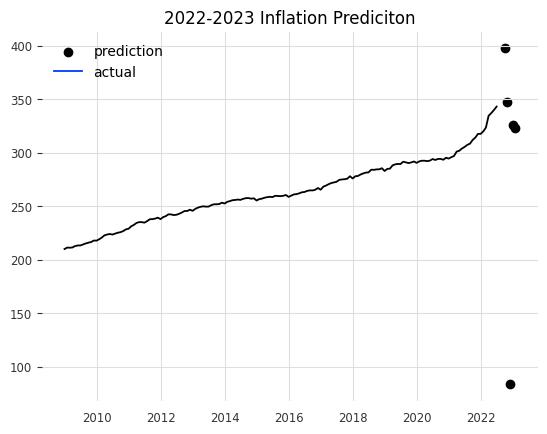

In [780]:
plt.plot(y)
plt.scatter(future_vals, test_results5['test_predictions'], label='prediction')
#plt.plot(test_results5['test_predictions'], label='prediction')
plt.plot(test_results5['test_actual'], label='actual')
plt.title('2022-2023 Inflation Prediciton')
plt.legend()